In [11]:
import requests
import os
import re
import cv2
import time
import shutil
import zipfile
import urllib.request
import numpy as np
from PIL import Image
from os import listdir
from os.path import isfile, join
from random import randrange
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

In [12]:
# returns a compiled model
# identical to the previous one
model = load_model('soil.h5')

# Constants
ENDPOINT_COMPLETIONS = "https://api.openai.com/v1/chat/completions"

# Global variables
API_KEY = input("Please enter your API key: ")

In [13]:
def classify_images(image_fp, model):
    classes = ['Gravel', 'Sand', 'Silt']
    gravel_count = 0
    sand_count = 0
    silt_count = 0

    img = cv2.imread(image_fp)
    img = cv2.resize(img,(1024,1024))
    im_dim = 256

    for r in range(0, img.shape[0], im_dim):
        for c in range(0, img.shape[1], im_dim):
            cropped_img = img[r:r + im_dim, c:c + im_dim, :]
            h, w, c = cropped_img.shape
            if h == im_dim and w == im_dim:
                classification = model_classify(cropped_img, model)
                if classification == classes[0]:
                    gravel_count += 1
                elif classification == classes[1]:
                    sand_count += 1
                elif classification == classes[2]:
                    silt_count += 1
            else:
                continue
    total_count = gravel_count + sand_count + silt_count
    proportion_array = [gravel_count / total_count, sand_count / total_count, silt_count / total_count]
    return proportion_array


def model_classify(cropped_img, model):
    classes = ['Gravel', 'Sand', 'Silt']
    image_array = cropped_img / 255.
    img_batch = np.expand_dims(image_array, axis=0)
    prediction_array = model.predict(img_batch)[0]
    first_idx = np.argmax(prediction_array)
    first_class = classes[first_idx]
    return first_class

# Helper function to get blurb from the chat completions api endpoint
def get_blurb(description):
    # Defines the prompt to send to the API based on title and theme
    prompt = f"What crops should be planted in soil with the following properties? ${description}"
    
    # Sends the request to the API
    response = requests.post(
        ENDPOINT_COMPLETIONS,
        json={
            "model": "gpt-3.5-turbo",
            "messages": [{"role": "user", "content": prompt}]
        },
        headers={
            "Content-type": "application/json",
            "Authorization": f"Bearer {API_KEY}"
        }
    )
    
    # Extracts the data from the response
    data = response.json()
    
    # Returns the blurb by extracting it from the JSON object
    return data["choices"][0]["message"]["content"]


def classify_percentage(image_url):
    local_image_path = 'image.jpg'  # Path to save the downloaded image
    downloaded_image_path = download_image(image_url, local_image_path)
    if downloaded_image_path:
        start = time.time()
        out = classify_images(image_fp=downloaded_image_path, model=model)
        finish = str(round(time.time() - start, 5))

        im = cv2.imread(downloaded_image_path)  # Load downloaded image
        plt.imshow(im[:, :, [2, 1, 0]])
        
        text_output = f'Percent Gravel: {round(out[0] * 100, 2)}%, Percent Sand: {round(out[1] * 100, 2)}%, Percent Silt: {round(out[2] * 100, 2)}%'
        
        print(text_output)


        try:
            # Gets blurb by calling the helper function
            blurb_text = get_blurb(text_output)
            print(blurb_text)
        
        except Exception as e:
            # Prints to console and displays alert if error occurs
            print("An error occurred.")

    else:
        print("Failed to download the image.")

# Define the download_image function
def download_image(image_url, save_path):
    response = requests.get(image_url)
    if response.status_code == 200:
        with open(save_path, 'wb') as f:
            f.write(response.content)
        return save_path
    else:
        return None

1/1 [==============================] - 0s 18ms/step
Percent Gravel: 100.0%, Percent Sand: 0.0%, Percent Silt: 0.0%
A soil with 100.0% gravel and 0.0% sand and silt would be classified as a pure gravel soil. This type of soil has a very coarse texture with poor water retention and drainage. The gravel particles do not provide enough surface area to hold nutrients and moisture for plant growth. 

Crops that require well-drained soil with good water retention may not thrive in pure gravel soil. However, there are certain crops that can tolerate or even benefit from gravel-rich soil conditions. These crops are typically drought-tolerant and have adapted to grow in coarse-textured soils. Here are a few crops that can be planted in pure gravel soil:

1. Cacti and Succulents: These plants have thick leaves and stems that store water, making them well-suited for environments with low water availability.

2. Lavender: Lavender is a drought-tolerant herb that can grow well in gravel soil. It req

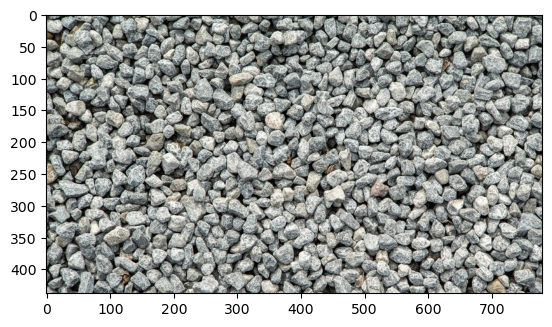

In [14]:
# silt
# percentage_photo = 'https://media.istockphoto.com/id/950553642/photo/clear-wet-sands-beach-texture-background.jpg?s=612x612&w=0&k=20&c=VHzmJEKNL2QslrPh1xyNM8iNTxQDEGLq8iit0VN70c4='

# gravel
percentage_photo = 'https://www.housedigest.com/img/gallery/what-are-the-different-types-of-gravel-to-consider/intro-1651672116.jpg'

# sand
# percentage_photo = 'https://www.investopedia.com/thmb/5OehRQwneiZA0LY7O7PMDwv_gDA=/1500x0/filters:no_upscale():max_bytes(150000):strip_icc()/sand-texture-in-the-beach-917396446-a71407b27e164c53a7bf0a89510074d4.jpg'

classify_percentage(image_url=percentage_photo)